Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Instantiating visualizer


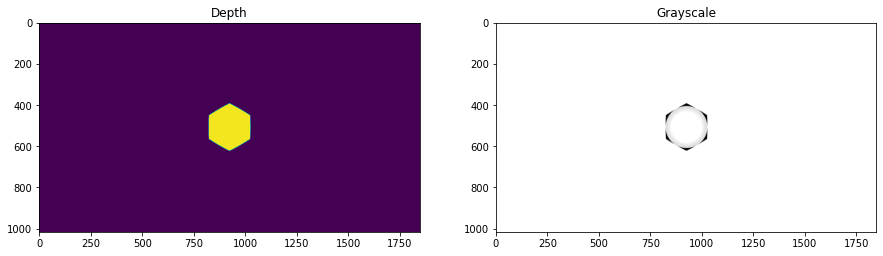

In [1]:
# read in untransformed bolt
# The untransformed location of the bolt is such that the center of the head is at 0,0,0
# and it is pointing in the direction and centered on the positive x axis.
# For example, rotating it around the z axis 90 degrees will make it appear pointing left
from utility.pose_data import get_bolt_depthimage, show_depthimage, make_pointcloud, get_random_transform
from utility.transformation_matrix import TransformationMatrix
from utility.visualizer import visualizer as vis

depthimage = get_bolt_depthimage()
show_depthimage(depthimage)

x=0.0, y=0.0, z=0.0
x_rotate=0.0°, y_rotate=0.0°, z_rotate=90.0°


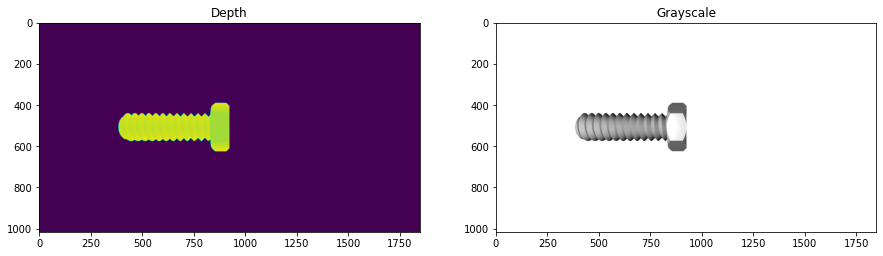

In [2]:
transform = TransformationMatrix.from_xyzwpr([0,0,0,0,0,90])
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)

x=12.99, y=-43.42, z=-7.15
x_rotate=0.0°, y_rotate=4.58°, z_rotate=-11.83°


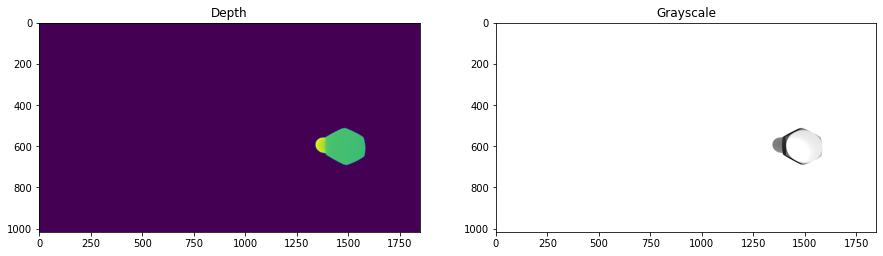

Now I'm a point cloud. Try moving me around!


In [3]:
transform = get_random_transform()
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)
pcd = make_pointcloud(depthimage.depth)
print('Now I\'m a point cloud. Try moving me around!')
vis.draw_geometries([pcd], moveable=False)

Truth
x=0.0, y=0.0, z=10.0
x_rotate=0.0°, y_rotate=20.0°, z_rotate=0.0°


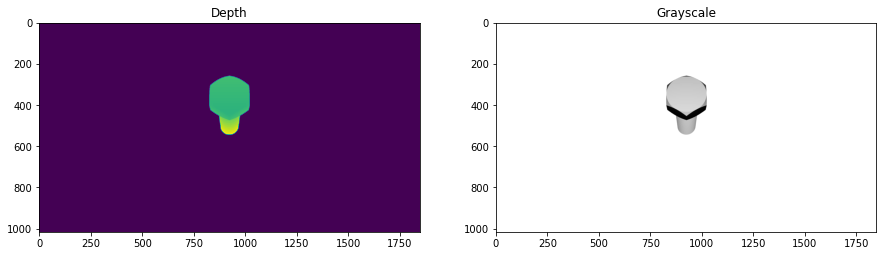

Estimate
x=4.02, y=-0.0, z=7.48
x_rotate=0.0°, y_rotate=0.0°, z_rotate=0.0°

Error: 8.392


In [5]:
import numpy as np
from scipy.spatial.transform import Rotation as R


def rotation_between_vectors(u, v):
    # u and v are both 3D unit vectors
    axis = np.cross(u, v)
    unit = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(u, v))
    rotvec = unit * angle
    return R.from_rotvec(rotvec)


def estimator(transformed_depthimage, debug=False):
    orig_normal = np.array([1,0,0]) # the bolt head is initially pointed in the x direction
    orig_center = np.array([0,0,0]) # the bolt head is initially centered at 0,0,0

    trns_pcd = make_pointcloud(transformed_depthimage)
    trns_center = trns_pcd.get_center()
    translation = (trns_center - orig_center)
    rot = np.zeros(3) # dummy values
    rot[0] = 0 # the rotation in x_rotate will always be 0 because I made that constraint
    rot = R.from_euler('xyz', rot).as_matrix()
    return TransformationMatrix.compose(rot, translation)

transform = TransformationMatrix.from_xyzwpr([0,0,10,0,20,0])
print('Truth')
print(transform)
transformed = get_bolt_depthimage(transform)
transformed_pcd = make_pointcloud(transformed)

show_depthimage(transformed)
vis.draw_geometries([transformed_pcd], moveable=False)
estimate = estimator(transformed, debug=False)
print('Estimate')
print(estimate)
from utility.pose_estimation import transform_error, evaluate_random

print('\nError:', transform_error(estimate, transform).round(3))

In [6]:
# you can use this convience function to get the loss on a random transformation
evaluate_random(estimator) 

11.462884990781282

In [7]:
from utility.pose_estimation import make_submission, test_images
import os
from tqdm import tqdm
os.environ["DISCORD_USERNAME"] = "josiah"

print('Estimating transformations')
estimates = np.array([estimator(img) for img in tqdm(test_images)])
make_submission(estimates)

Estimating transformations


100%|██████████| 200/200 [00:03<00:00, 59.84it/s]


Mean rmse=5.3817
Your ranking: #1

In [8]:
from utility.scoring_client import get_highscores, get_myscores, Challenge
get_highscores(Challenge.POSE)

In [ ]:
get_myscores(Challenge.POSE)